## Test making densities and running samplers

#### Need to make some good target densities

#### Need to make sure NUTS, MCLMC, and MAMS all work with auto-tuned hyperparameters and fixed given hyperparameters

In [80]:
# Imports from here: https://blackjax-devs.github.io/sampling-book/algorithms/mclmc.html#how-to-run-mclmc-in-blackjax

import matplotlib.pyplot as plt

plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["font.size"] = 12 # Changed from 19 to 12

import jax
import blackjax
import numpy as np
import jax.numpy as jnp
from datetime import date
import numpyro
import numpyro.distributions as dist

from numpyro.infer.util import initialize_model

rng_key = jax.random.key(548) # Changed


# Imports for Adjusted MCLMC (MAMS):
# See: https://blackjax-devs.github.io/sampling-book/algorithms/mclmc.html#adjusted-mclmc
from blackjax.mcmc.adjusted_mclmc_dynamic import rescale
from blackjax.util import run_inference_algorithm


# Additional imports for NUTS:
# See: https://blackjax-devs.github.io/blackjax/examples/quickstart.html#nuts
import jax.scipy.stats as stats


# JAX guide: https://docs.jax.dev/en/latest/notebooks/thinking_in_jax.html
# Blackjax guide: https://blackjax-devs.github.io/sampling-book/

# Bayes Opt for JAX
# Boax guide: https://boax.readthedocs.io/en/latest/index.html
from boax.experiments import optimization

# Make JAX work
from jax import config
config.update("jax_enable_x64", True)

# Time the experiments
import time

# Use ARVIZ for MCMC diagnostics 
# See: https://python.arviz.org/en/stable/api/diagnostics.html
import arviz as az
import xarray as xr



# Make more seeds for tuning and validation
# Class is 548, it's 2025, you know
SEED_NUTS_TUNING = 548
SEED_MCLMC_TUNING = 548
SEED_MAMS_TUNING = 548
SEED_BAYESOPT_VALIDATION = 2025
SEED_AUTO_VALIDATION = 2025

#### Make R hat and ESS functions

In [81]:

# Find ESS (Effective Sample Size)
def compute_ess(samples):
    # See: https://python.arviz.org/en/stable/api/generated/arviz.ess.html
    # Need to match the expected structure
    samples_np = np.array(samples)
    
    # Arviz expects (chain, draw, *variable_shape)
    samples_reshaped = samples_np[None, :, :]
    
    # Convert to Arviz dataset: https://python.arviz.org/en/stable/api/generated/arviz.convert_to_dataset.html#arviz.convert_to_dataset
    dataset = az.convert_to_dataset(samples_reshaped)
    
    # Compute ESS
    ess = az.ess(dataset, method = 'bulk')
    
     # Return worst, want to maximize the minimum ESS (maximin)
    return float(np.min([ess[var].values for var in ess.data_vars]))


# Find R-hat
def compute_rhat(chains): 
    # Arviz R-hat: Compute estimate of rank normalized splitR-hat for a set of traces.
    # https://python.arviz.org/en/stable/api/generated/arviz.rhat.html#arviz.rhat
    chains_np = np.array(chains)
    dataset = az.convert_to_dataset(chains_np)
    
    # Compute R-hat
    rhat = az.rhat(dataset)
    
    # Return worst, want to minimize maximum R-hat (minimax)
    return float(np.max([rhat[var].values for var in rhat.data_vars]))


#### Make some densities

In [82]:
def make_funnel_logdensity(dim):
    
    def logdensity(x):
        
        # First dimension is normal(0, 3^2)
        log_prob = -0.5 * (x[0]**2 / 9.0)
        
        # Normalizing constant for first dimension
        log_prob += -0.5 * (dim - 1) * x[0]
        
        # Other dimensions are normal(0, exp(x[0]/2))
        log_prob += -0.5 * jnp.sum(x[1:]**2 * jnp.exp(-x[0]))
        
        return log_prob
    
    return logdensity

In [83]:
def make_rosenbrock_logdensity(dim, a=1.0, b=100.0):
    
    def logdensity(x):
        log_prob = 0.0
        for i in range(dim - 1):
            log_prob += -((a - x[i])**2 + b * (x[i+1] - x[i]**2)**2)
        return log_prob
    
    return logdensity

In [84]:
def make_correlated_gaussian_logdensity(dim, correlation=0.9):
    
    # Create covariance matrix
    cov = jnp.eye(dim) * (1 - correlation) + jnp.ones((dim, dim)) * correlation
    cov_inv = jnp.linalg.inv(cov)
    log_det = jnp.linalg.slogdet(cov)[1]
    
    def logdensity(x):
        # Multivariate normal log density
        return -0.5 * (x @ cov_inv @ x + log_det + dim * jnp.log(2 * jnp.pi))
    
    return logdensity

In [85]:
def make_heavy_tailed_logdensity(dim, df=3.0):
    
    def logdensity(x):
        # Student-t log density with df degrees of freedom
        return -(df + dim) / 2.0 * jnp.log(1 + jnp.sum(x**2) / df)
    
    return logdensity

#### Put the sampler algorithms here

In [86]:
# Run MCLMC with fixed step size and L for optimizing with BayesOpt
# https://blackjax-devs.github.io/sampling-book/algorithms/mclmc.html#how-to-run-mclmc-in-blackjax
def run_mclmc_fixed(
    logdensity_fn, 
    chain_length, 
    initial_position, 
    key, 
    L, 
    step_size
    ):
    
    # Start timing
    start_time = time.time()
    
    # initialization and sampling key/seed
    init_key, run_key = jax.random.split(key)
    
    # Initialize MCLMC
    initial_state = blackjax.mcmc.mclmc.init(
        position = initial_position, 
        logdensity_fn = logdensity_fn, 
        rng_key = init_key
    )
    
    # Use the given hyperparameters
    sampling_alg = blackjax.mclmc(
        logdensity_fn = logdensity_fn,
        L = L,
        step_size = step_size,
    )
    
    # Run the chain
    _, samples = blackjax.util.run_inference_algorithm(
        rng_key = run_key,
        initial_state = initial_state,
        inference_algorithm = sampling_alg,
        num_steps = chain_length,
        transform = lambda state, _: state.position,
        progress_bar = False
        )
    
    # Summary stats
    ess = compute_ess(samples)
    avg_acceptance = 1.0  # MCLMC never rejects
    integration_steps_per_iter = L / step_size
    time_elapsed = time.time() - start_time
    
    return samples, ess, avg_acceptance, integration_steps_per_iter, time_elapsed



In [87]:
def plot_2d_samples(samples, title="Samples", save_name=None):
    """Plot 2D samples with trace"""
    if samples.shape[1] != 2:
        print(f"Skipping 2D plot - dimension is {samples.shape[1]}")
        return
    
    x = samples[:, 0]
    y = samples[:, 1]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Scatter + trace
    ax1.scatter(x, y, s=10, alpha=0.6, c=range(len(x)), cmap='viridis', label='Samples')
    ax1.plot(x, y, color='gray', alpha=0.25, linewidth=1)
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_title(f'{title} - Trace')
    ax1.grid(True, alpha=0.3)
    
    # Hexbin density
    hb = ax2.hexbin(x, y, gridsize=30, cmap='viridis', mincnt=1)
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_title(f'{title} - Density')
    plt.colorbar(hb, ax=ax2, label='Count')
    
    plt.tight_layout()
    
    if save_name:
        plt.savefig(f'{save_name}.png', dpi=150, bbox_inches='tight')
    
    plt.show()

In [88]:
def plot_arviz_diagnostics(samples, var_names=None, title="Diagnostics"):
    """Create ArviZ diagnostic plots"""
    # Convert to ArviZ InferenceData
    if var_names is None:
        var_names = [f"x{i}" for i in range(samples.shape[1])]
    
    posterior_dict = {name: samples[:, i] for i, name in enumerate(var_names)}
    idata = az.from_dict(posterior=posterior_dict)
    
    # Trace plot
    print(f"\n{title} - Trace Plot:")
    az.plot_trace(idata)
    plt.suptitle(f'{title} - Trace Plot', y=1.02)
    plt.tight_layout()
    plt.show()
    
    # Only plot pairs for 2D
    if samples.shape[1] == 2:
        print(f"\n{title} - Pair Plot (Scatter):")
        az.plot_pair(idata, kind="scatter", marginals=True)
        plt.suptitle(f'{title} - Scatter', y=1.02)
        plt.show()
        
        print(f"\n{title} - Pair Plot (KDE):")
        az.plot_pair(idata, kind="kde", marginals=True)
        plt.suptitle(f'{title} - KDE', y=1.02)
        plt.show()
    
    # Autocorrelation
    print(f"\n{title} - Autocorrelation:")
    az.plot_autocorr(idata, max_lag=50)
    plt.suptitle(f'{title} - Autocorrelation', y=1.02)
    plt.tight_layout()
    plt.show()

In [89]:
def test_nuts_fixed():
    """Test NUTS with fixed hyperparameters"""
    print("\n" + "="*80)
    print("TESTING: run_nuts_fixed")
    print("="*80)
    
    # Setup
    logdensity = make_funnel_logdensity(dim=2)
    chain_length = 1000
    initial_position = jnp.array([0.0, 0.0])
    key = jax.random.PRNGKey(0)
    step_size = 0.5
    inv_mass_matrix = jnp.array([1.0, 1.0])
    
    # Run
    samples, ess, avg_acceptance, integration_steps, time_elapsed = run_nuts_fixed(
        logdensity_fn=logdensity,
        chain_length=chain_length,
        initial_position=initial_position,
        key=key,
        step_size=step_size,
        inv_mass_matrix=inv_mass_matrix
    )
    
    # Print results
    print(f"Average acceptance: {avg_acceptance:.3f}")
    print(f"Effective sample size: {ess:.1f}")
    print(f"Integration steps per iteration: {integration_steps:.1f}")
    print(f"Time elapsed: {time_elapsed:.2f}s")
    print(f"First 5 samples:\n{samples[:5]}")
    
    # Visualize
    plot_2d_samples(samples, title="NUTS Fixed - Funnel")
    plot_arviz_diagnostics(samples, var_names=["x", "y"], title="NUTS Fixed")
    
    return samples


In [90]:
def test_mclmc_fixed():
    """Test MCLMC with fixed hyperparameters"""
    print("\n" + "="*80)
    print("TESTING: run_mclmc_fixed")
    print("="*80)
    
    # Setup
    logdensity = make_rosenbrock_logdensity(dim=2)
    chain_length = 1000
    initial_position = jnp.array([0.0, 0.0])
    key = jax.random.PRNGKey(42)
    L = 5.0
    step_size = 0.1
    
    # Run
    samples, ess, avg_acceptance, integration_steps, time_elapsed = run_mclmc_fixed(
        logdensity_fn=logdensity,
        chain_length=chain_length,
        initial_position=initial_position,
        key=key,
        L=L,
        step_size=step_size
    )
    
    # Print results
    print(f"Acceptance rate: {avg_acceptance:.3f} (always 1.0 for MCLMC)")
    print(f"Effective sample size: {ess:.1f}")
    print(f"Integration steps per iteration: {integration_steps:.1f}")
    print(f"Time elapsed: {time_elapsed:.2f}s")
    print(f"First 5 samples:\n{samples[:5]}")
    
    # Visualize
    plot_2d_samples(samples, title="MCLMC Fixed - Rosenbrock")
    plot_arviz_diagnostics(samples, var_names=["x", "y"], title="MCLMC Fixed")
    
    return samples



TESTING: run_mclmc_fixed
Acceptance rate: 1.000 (always 1.0 for MCLMC)
Effective sample size: 8.9
Integration steps per iteration: 50.0
Time elapsed: 0.99s
First 5 samples:
[[ 0.04578763  0.08681056]
 [ 0.13305247  0.05852199]
 [ 0.20780692 -0.00771302]
 [ 0.29357288 -0.02542884]
 [ 0.30581588  0.06943449]]


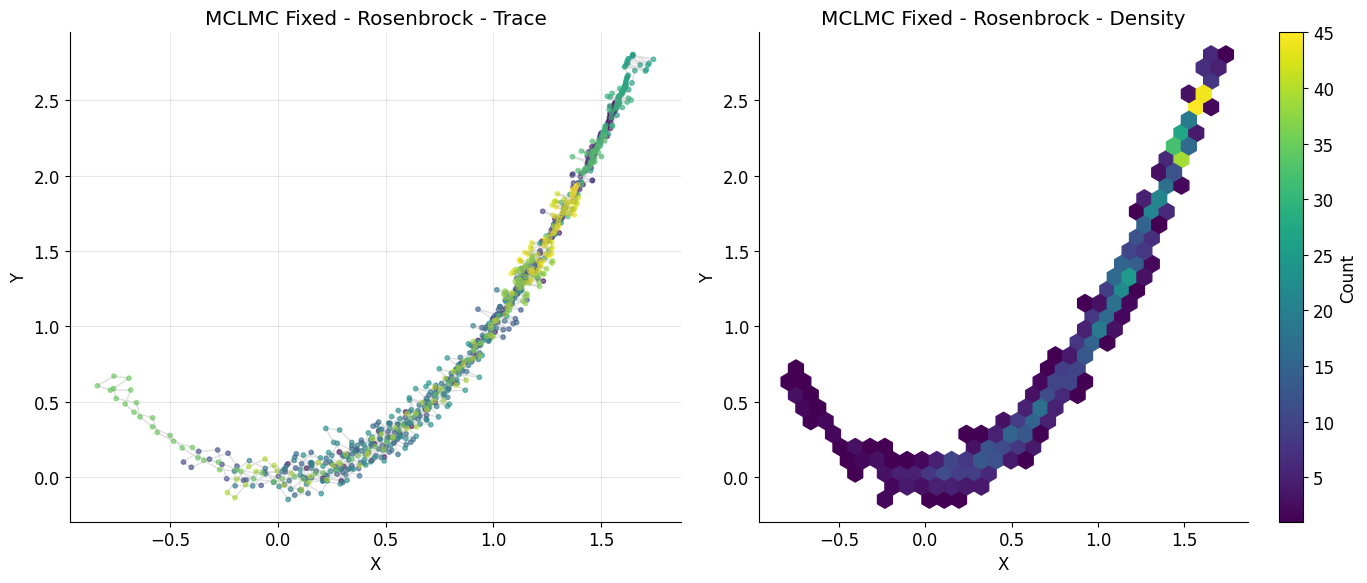


MCLMC Fixed - Trace Plot:


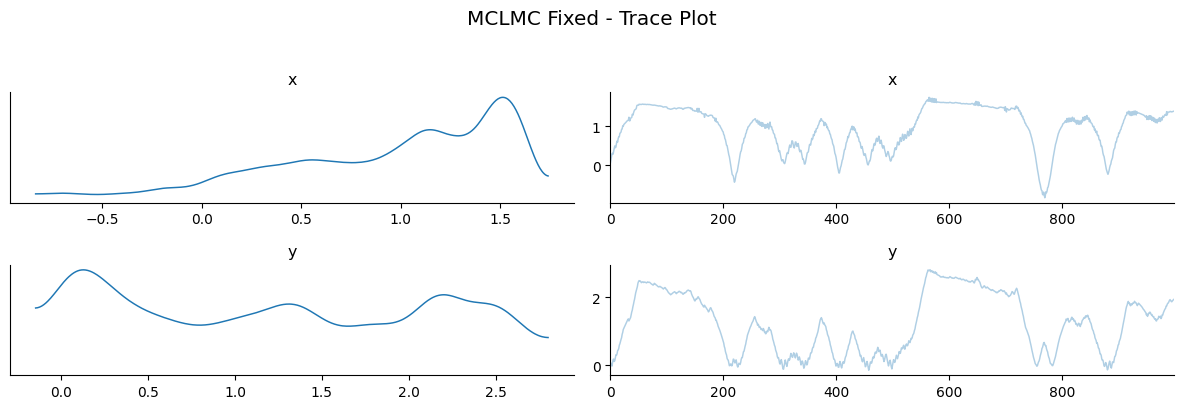


MCLMC Fixed - Pair Plot (Scatter):


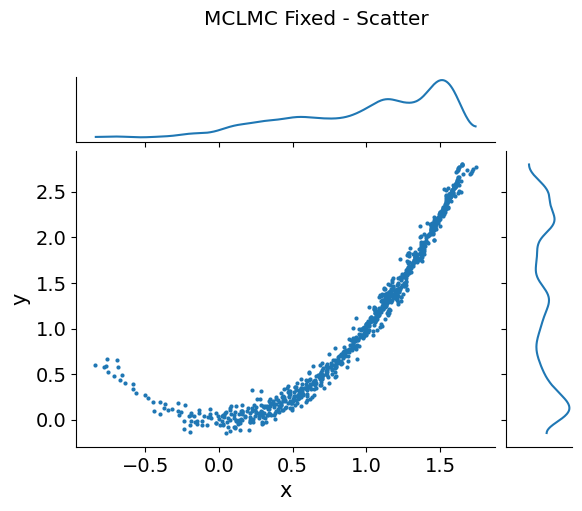


MCLMC Fixed - Pair Plot (KDE):


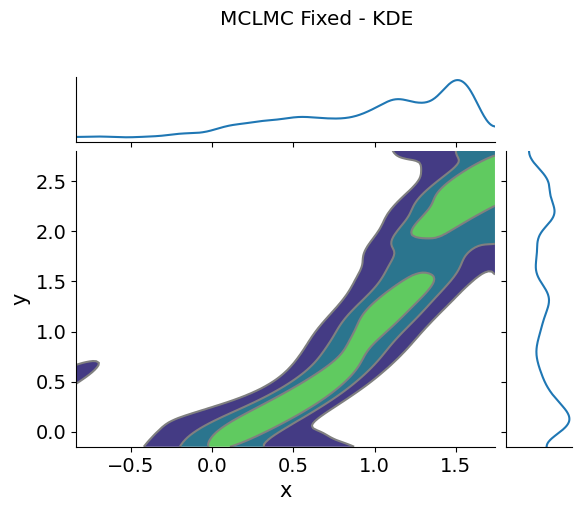


MCLMC Fixed - Autocorrelation:


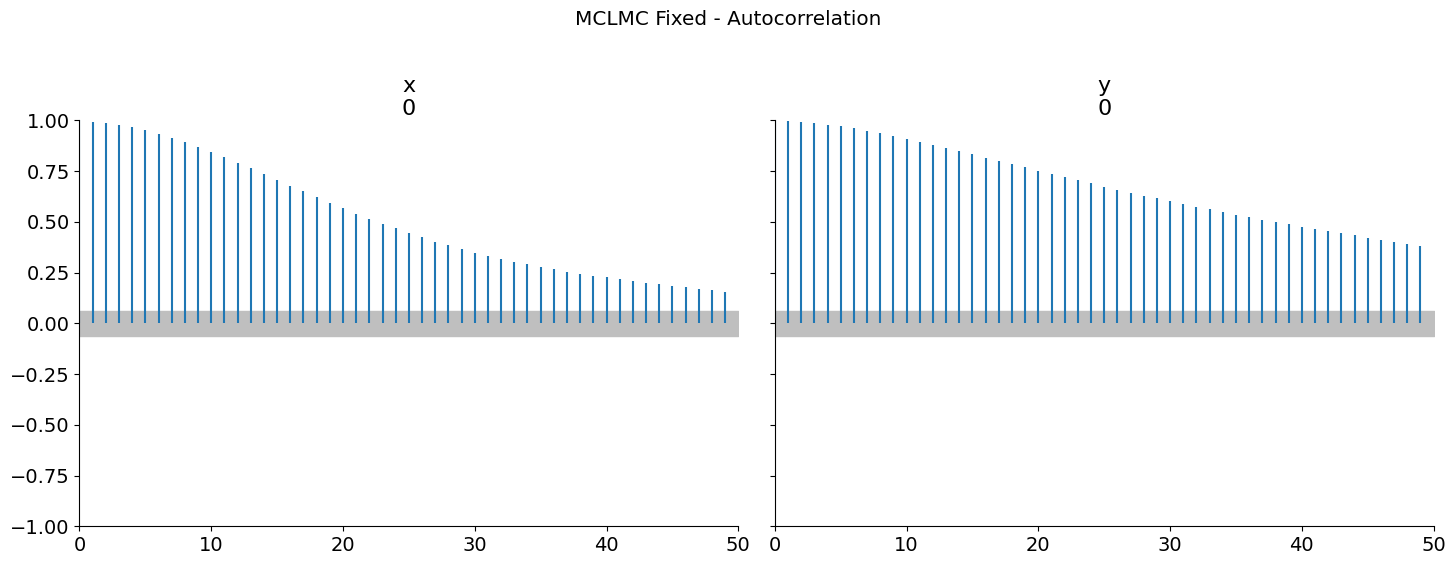

Array([[ 0.04578763,  0.08681056],
       [ 0.13305247,  0.05852199],
       [ 0.20780692, -0.00771302],
       ...,
       [ 1.3769833 ,  1.90908035],
       [ 1.38439881,  1.92424635],
       [ 1.38877552,  1.93852847]], dtype=float64)

In [91]:
test_mclmc_fixed()

In [92]:
def test_mams_fixed():
    """Test MAMS with fixed hyperparameters"""
    print("\n" + "="*80)
    print("TESTING: run_mams_fixed")
    print("="*80)
    
    # Setup
    logdensity = make_correlated_gaussian_logdensity(dim=2, correlation=0.8)
    chain_length = 1000
    initial_position = jnp.array([0.0, 0.0])
    key = jax.random.PRNGKey(123)
    L = 3.0
    step_size = 0.15
    
    # Run
    samples, ess, avg_acceptance, integration_steps, time_elapsed = run_mams_fixed(
        logdensity_fn=logdensity,
        chain_length=chain_length,
        initial_position=initial_position,
        key=key,
        L=L,
        step_size=step_size
    )
    
    # Print results
    print(f"Average acceptance: {avg_acceptance:.3f}")
    print(f"Effective sample size: {ess:.1f}")
    print(f"Integration steps per iteration: {integration_steps:.1f}")
    print(f"Time elapsed: {time_elapsed:.2f}s")
    print(f"First 5 samples:\n{samples[:5]}")
    
    # Visualize
    plot_2d_samples(samples, title="MAMS Fixed - Correlated Gaussian")
    plot_arviz_diagnostics(samples, var_names=["x", "y"], title="MAMS Fixed")
    
    return samples

In [93]:
def test_nuts_auto():
    """Test NUTS with automatic tuning"""
    print("\n" + "="*80)
    print("TESTING: run_nuts_auto")
    print("="*80)
    
    # Setup
    logdensity = make_heavy_tailed_logdensity(dim=2, df=3.0)
    num_steps = 1000
    initial_position = jnp.array([0.0, 0.0])
    key = jax.random.PRNGKey(456)
    
    # Run
    samples, step_size, inv_mass_matrix, avg_acceptance, avg_integration_steps, time_elapsed = run_nuts_auto(
        logdensity_fn=logdensity,
        num_steps=num_steps,
        initial_position=initial_position,
        key=key
    )
    
    # Print results
    print(f"Tuned step size: {step_size:.6f}")
    print(f"Tuned inverse mass matrix: {inv_mass_matrix}")
    print(f"Average acceptance: {avg_acceptance:.3f}")
    print(f"Average integration steps: {avg_integration_steps:.1f}")
    print(f"Time elapsed (including tuning): {time_elapsed:.2f}s")
    print(f"First 5 samples:\n{samples[:5]}")
    
    # Visualize
    plot_2d_samples(samples, title="NUTS Auto - Heavy Tailed")
    plot_arviz_diagnostics(samples, var_names=["x", "y"], title="NUTS Auto")
    
    return samples

In [94]:
def test_mclmc_auto():
    """Test MCLMC with automatic tuning"""
    print("\n" + "="*80)
    print("TESTING: run_mclmc_auto")
    print("="*80)
    
    # Setup
    logdensity = make_funnel_logdensity(dim=2)
    num_steps = 1000
    initial_position = jnp.array([0.0, 0.0])
    key = jax.random.PRNGKey(789)
    
    # Run
    samples, step_size, L, time_elapsed = run_mclmc_auto(
        logdensity_fn=logdensity,
        num_steps=num_steps,
        initial_position=initial_position,
        key=key
    )
    
    # Get ESS
    ess = compute_ess(samples)
    
    # Print results
    print(f"Tuned L: {L:.6f}")
    print(f"Tuned step size: {step_size:.6f}")
    print(f"Effective sample size: {ess:.1f}")
    print(f"Time elapsed (including tuning): {time_elapsed:.2f}s")
    print(f"First 5 samples:\n{samples[:5]}")
    
    # Visualize
    plot_2d_samples(samples, title="MCLMC Auto - Funnel")
    plot_arviz_diagnostics(samples, var_names=["x", "y"], title="MCLMC Auto")
    
    return samples

In [95]:
def test_mams_auto():
    """Test MAMS with automatic tuning"""
    print("\n" + "="*80)
    print("TESTING: run_mams_auto")
    print("="*80)
    
    # Setup
    logdensity = make_rosenbrock_logdensity(dim=2)
    num_steps = 1000
    initial_position = jnp.array([0.0, 0.0])
    key = jax.random.PRNGKey(999)
    
    # Run
    samples, step_size, L, time_elapsed = run_mams_auto(
        logdensity_fn=logdensity,
        num_steps=num_steps,
        initial_position=initial_position,
        key=key
    )
    
    # Get ESS
    ess = compute_ess(samples)
    
    # Print results
    print(f"Tuned L: {L:.6f}")
    print(f"Tuned step size: {step_size:.6f}")
    print(f"Effective sample size: {ess:.1f}")
    print(f"Time elapsed (including tuning): {time_elapsed:.2f}s")
    print(f"First 5 samples:\n{samples[:5]}")
    
    # Visualize
    plot_2d_samples(samples, title="MAMS Auto - Rosenbrock")
    plot_arviz_diagnostics(samples, var_names=["x", "y"], title="MAMS Auto")
    
    return samples


In [96]:
def test_target_densities():
    """Test all target densities"""
    print("\n" + "="*80)
    print("TESTING: All Target Densities")
    print("="*80)
    
    dim = 2
    x_test = jnp.array([1.0, 2.0])
    
    # Test Funnel
    funnel = make_funnel_logdensity(dim)
    print(f"Funnel log density at {x_test}: {funnel(x_test):.4f}")
    
    # Test Rosenbrock
    rosenbrock = make_rosenbrock_logdensity(dim)
    print(f"Rosenbrock log density at {x_test}: {rosenbrock(x_test):.4f}")
    
    # Test Correlated Gaussian
    corr_gauss = make_correlated_gaussian_logdensity(dim, correlation=0.9)
    print(f"Correlated Gaussian log density at {x_test}: {corr_gauss(x_test):.4f}")
    
    # Test Heavy Tailed
    heavy = make_heavy_tailed_logdensity(dim, df=3.0)
    print(f"Heavy Tailed log density at {x_test}: {heavy(x_test):.4f}")
    
    print("\nAll target densities working!")
